Set up system.

In [1]:
%matplotlib inline

import pandas as pd
import pymc3  as pm
import numpy  as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from scipy import stats

Access data.

In [2]:
df_data = pd.read_csv('test_daten_ab.csv', delimiter=';', header=None, names=["group", "value"])

Inspect and prepare data.

In [3]:
df_data.head()

,group,value
0,2,0
1,2,0
2,1,0
3,2,0
4,2,"372,83"


In [4]:
obs_A = pd.to_numeric(df_data[df_data.group == 1]['value'].str.replace(',', '.'))
obs_B = pd.to_numeric(df_data[df_data.group == 2]['value'].str.replace(',', '.'))

In [5]:
obs_A.describe()

count    300000.000000
mean         32.922682
std          90.438431
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        5667.570000
Name: value, dtype: float64

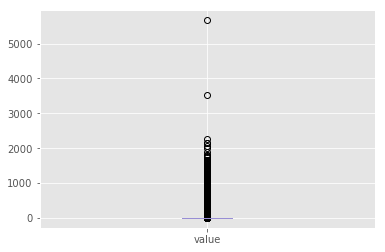

In [6]:
_ = obs_A.plot.box()

In [7]:
obs_A = obs_A[obs_A < 3000]

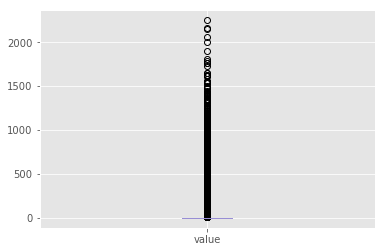

In [8]:
_ = obs_A.plot.box()

In [9]:
obs_B.describe()

count    300000.000000
mean         32.369469
std          88.733991
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        2413.570000
Name: value, dtype: float64

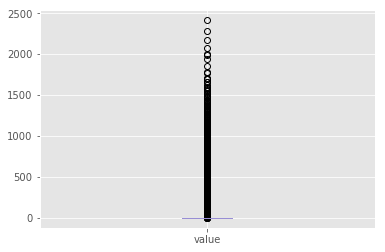

In [10]:
_ = obs_B.plot.box()

Fit empirical distribution to data. Possible candidates:

- Weibull family (for the maximum)
- Gamma family
- Chi-square family
- Lognormal family
- Power lognormal family

Try Gamma distribution.

In [11]:
x = np.linspace (0, 2000)

shape_A, loc_A, scale_A = stats.gamma.fit(obs_A)
shape_B, loc_B, scale_B = stats.gamma.fit(obs_B)

y_A = stats.gamma.pdf(x=x, a=shape_A, scale=scale_A)
y_B = stats.gamma.pdf(x=x, a=shape_B, scale=scale_B)

Plot fitting.

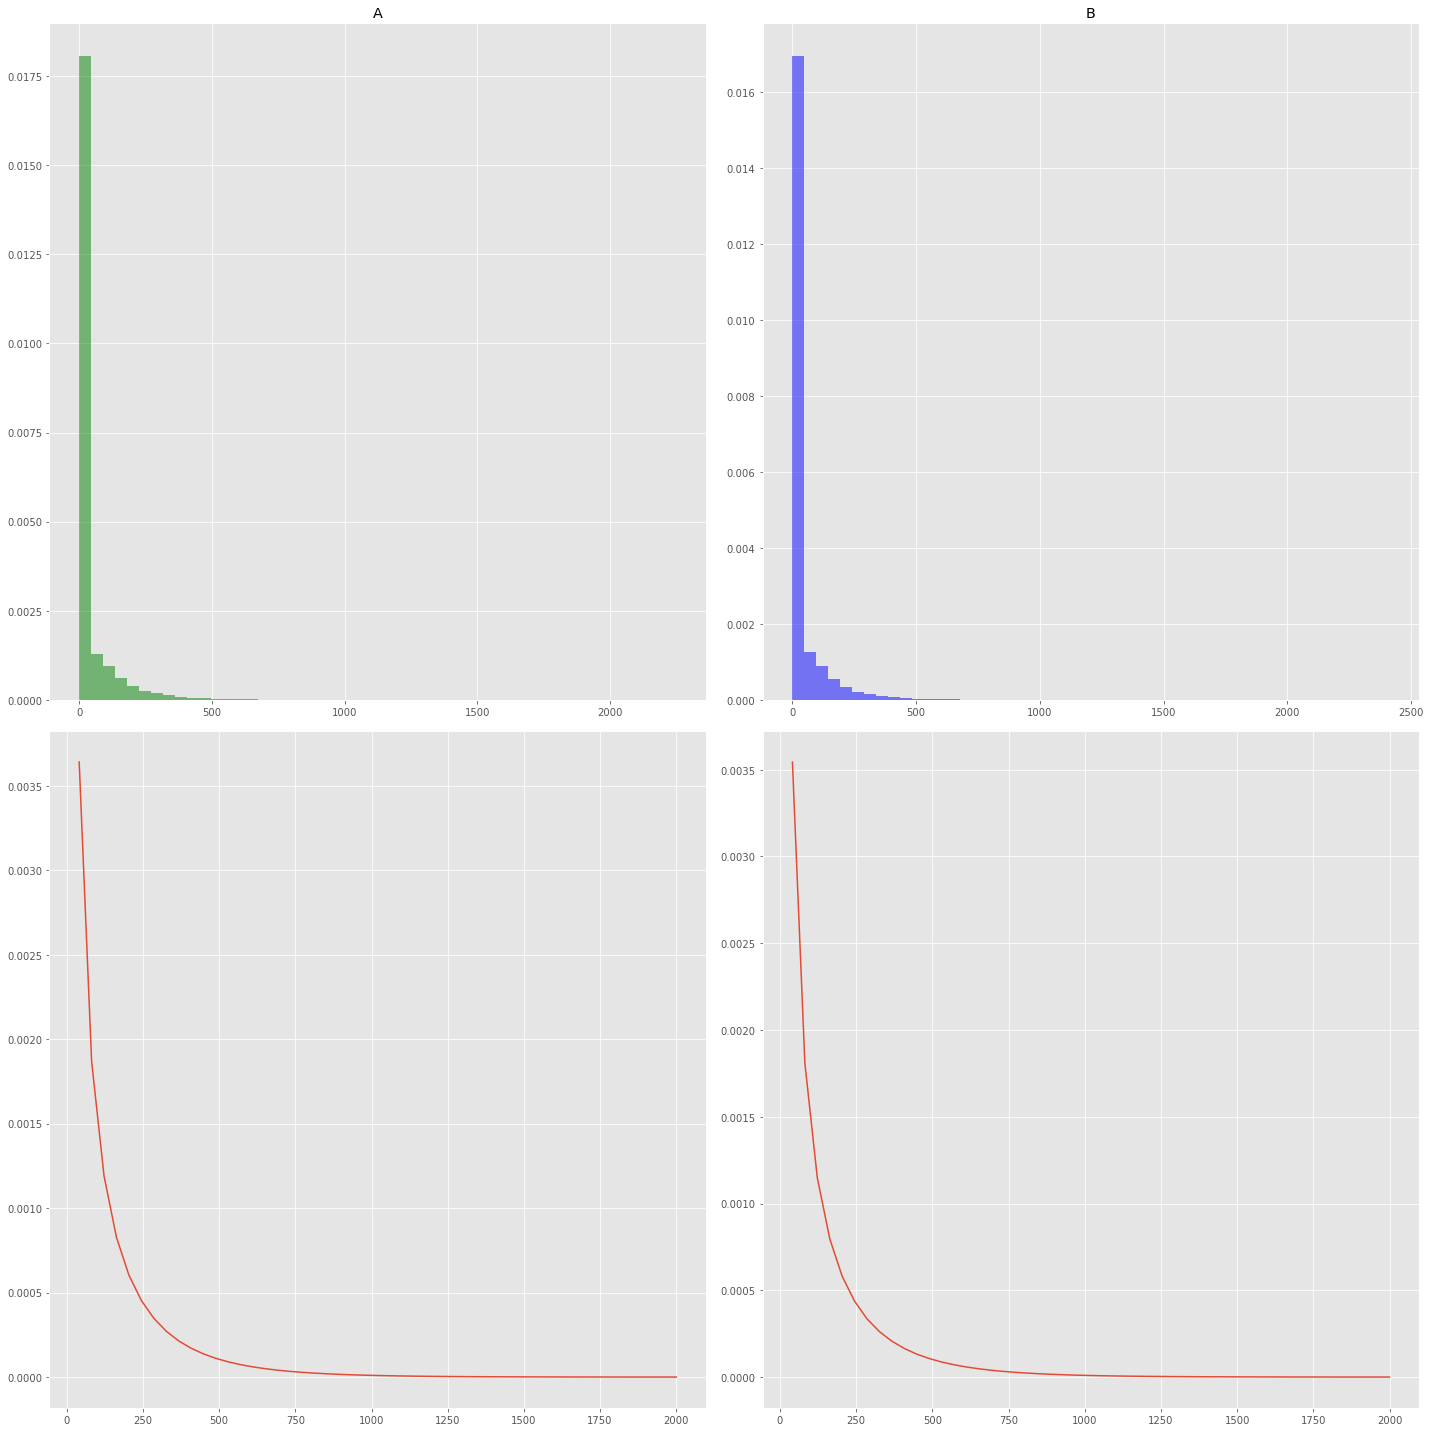

In [12]:
fig, [[ax0, ax1], [ax2, ax3]] = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

num_bins = 50

# Histograms of the data.
ax0.hist(obs_A, bins=50, normed=True, alpha=0.50, color='g')
ax1.hist(obs_B, bins=50, normed=True, alpha=0.50, color='b')

# Fitted Gamma functions.
ax2.plot(x, y_A)
ax3.plot(x, y_B)

ax0.set_title('A')
ax1.set_title('B')

fig.tight_layout()
plt.show()

Calculate a-posteriori distribution.

In [13]:
with pm.Model() as model:
    
    # Definiere a-priori Verteilungen für nicht beobachteten Zufallsvariablen.
    mu_A = pm.HalfNormal('mu_A', sd=1)
    sd_A = pm.HalfNormal('sd_A', sd=1)
    mu_B = pm.HalfNormal('mu_B', sd=1)
    sd_B = pm.HalfNormal('sd_B', sd=1)
    
    alpha_A = pm.Deterministic('alpha_A', mu_A**2/sd_A**2)
    beta_A  = pm.Deterministic('beta_A' , mu_A/sd_A**2)
    alpha_B = pm.Deterministic('alpha_B', mu_B**2/sd_B**2)
    beta_B  = pm.Deterministic('beta_B' , mu_B/sd_B**2)
    
    # Definiere Likelihood Verteilung für beobachtete Zufallsvariablen.
    obs_A = pm.Gamma("obs_A", alpha=alpha_A, beta=beta_A, observed=obs_A)
    obs_B = pm.Gamma("obs_B", alpha=alpha_B, beta=beta_B, observed=obs_B)
    
    # Definiere die notwendigen Evaluierungsmetriken.
    delta = pm.Deterministic("delta", pm.Gamma('A', alpha_A, beta_A) - pm.Gamma('B', alpha_B, beta_B))

    # Bayes'sche Inferenz.
    trace = pm.sample(draws=5000)
    burned_trace=trace[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -inf: 100%|██████████| 200000/200000 [33:15<00:00, 100.24it/s]
Finished [100%]: Average ELBO = -inf
100%|██████████| 5000/5000 [01:38<00:00, 50.70it/s]


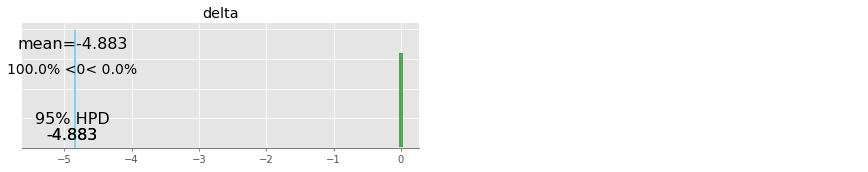

In [14]:
_ = pm.plot_posterior(trace[1000:], varnames=['delta'], ref_val=0, color='#87ceeb')